# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/home/straight/Programming/JupyterNotebook/DRL nanodegree/3. Policy-Based methods/p2_continuous-control/Reacher_Linux/Reacher.x86_64')
#env = UnityEnvironment(file_name='/home/straight/Programming/JupyterNotebook/DRL nanodegree/3. Policy-Based methods/p2_continuous-control/Reacher_Linux/Reacher.x86_64', no_graphics=True)



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.14299999680370093


### 4. DDPG agent

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
# import packages
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline

from ddpg_agent import Agent

In [6]:
# load the agent with DDPG algorithm
agent = Agent(state_size=state_size, action_size=action_size, n_agents = num_agents, random_seed=2)

LR_Actor 0.0001


#### train the agent using DDPG

In [8]:
score_threshold=30.0

def ddpg(n_episodes=1000, max_t=2000, print_interval=20):
    
    scores_deque = deque(maxlen=100)
    scores = []         # initialize scores for all episodes
    max_score = -np.Inf
    
    time_elapsed = 0 # initialize the time
    
    ### start training ###
    for i_episode in range(1, n_episodes+1):
        time_beginning = time.time() # starting time for this episode
        # initialize the environment
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
        states = env_info.vector_observations                # get the current state (for each agent)
        
        agent.reset()     # reset the agent
        episode_score = np.zeros(num_agents) # initialize the score in one episode 
        
        ###### start one episode training
        for t in range(max_t):
            actions = agent.act(states)                      # select an action (for each agent) using DDPG
            
            # take actions
            env_info = env.step(actions)[brain_name]        # send all actions to tne environment 
            next_states = env_info.vector_observations      # get next state (for each agent)
            rewards = env_info.rewards                      # get reward (for each agent
            dones = env_info.local_done                     # see if episode finished

            agent.step(states, actions, rewards, next_states, dones, t)
            #print("***Reward:", rewards) # test
            episode_score += np.array(rewards)
            states = next_states
            if np.any(dones):
                break
        ##### end of max_t (finish one episode)
        time_end = time.time() # ending time for this episode
        # calculate the scores
        mean_episode_score = np.mean(episode_score)    # take average scores for one episode
        
        scores_deque.append(mean_episode_score)
        average_score = np.mean(scores_deque) # average scores
        
        scores.append(mean_episode_score) # attach episode score to scores (for all episode)
        
        # calculate time
        time_elapsed = time_elapsed + (time_end - time_beginning) # how much time it takes for one episodes

        # save the weights
        print('\rEpisode {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}\tTime: {:.2f} s'.format(i_episode, average_score, mean_episode_score, time_elapsed), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        # print average scores
        if i_episode % print_interval == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}\tTime: {:.2f} s'.format(i_episode, average_score, mean_episode_score, time_elapsed))
        
        # stop the training the score is more than required
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
        # stop the training if it doesn't work
        if i_episode > 30 and average_score < 0.1:
            print("\nThe training has stopped because it is not working. Please redesign the algorithm")
            break
            
    ### end of training (finished all episodes)

        
    np.save('scores.npy', scores)
    return scores


In [9]:
scores = ddpg()

Episode 20	Average Score: 0.20	Current Score: 0.36	Time: 244.77 s
Episode 40	Average Score: 0.75	Current Score: 1.93	Time: 564.79 s
Episode 60	Average Score: 1.59	Current Score: 4.49	Time: 917.47 s
Episode 80	Average Score: 2.53	Current Score: 6.86	Time: 1290.02 s
Episode 100	Average Score: 3.47	Current Score: 8.39	Time: 1666.56 s
Episode 120	Average Score: 5.17	Current Score: 9.91	Time: 2031.40 s
Episode 140	Average Score: 7.10	Current Score: 13.08	Time: 2389.38 s
Episode 160	Average Score: 9.16	Current Score: 15.09	Time: 2756.69 s
Episode 180	Average Score: 11.31	Current Score: 16.61	Time: 3113.99 s
Episode 200	Average Score: 13.68	Current Score: 19.95	Time: 3472.58 s
Episode 220	Average Score: 16.47	Current Score: 26.39	Time: 3837.45 s
Episode 240	Average Score: 19.81	Current Score: 32.25	Time: 4210.14 s
Episode 260	Average Score: 23.78	Current Score: 33.03	Time: 4586.21 s
Episode 280	Average Score: 27.59	Current Score: 35.17	Time: 4954.08 s
Episode 295	Average Score: 30.05	Current 

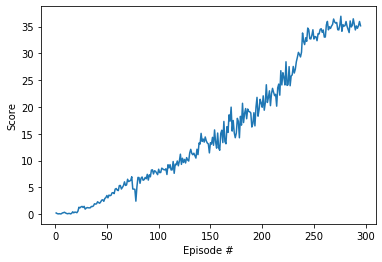

In [10]:
# plot the reward figures
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5 Run the trained agent

In [7]:
# load the weights to the agent
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [8]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agent.act(states)       # select an action (for each agent)
    
    # take action
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 36.15799919180572


### 6. Close the environment

When finished, you can close the environment.

In [ ]:
env.close()